**Methods**

1. Kaplan-Meier Survival Curves

    Plotted survival estimates by patient subgroup (e.g., treatment type, tumor stage, smoking status).

    Log-rank test used to evaluate statistical differences in survival.

2. Cox Proportional Hazards Model

    Included multiple covariates to assess risk factors.

    Validated proportional hazards assumption.

3. Random Survival Forests

    Trained RSF model using sksurv.ensemble.

    Computed variable importance and compared C-index to Cox model.

**Evaluation Metrics**

Log-rank Test – Used for group comparison in Kaplan-Meier plots.

Concordance Index (C-index) – Used to evaluate the predictive accuracy of Cox and RSF models.

Variable Importance – Ranked predictive covariates from RSF.

# Data Preprocessing


**Data Exploration:** 

3,346 row x 34 columns 
High number of missing values 
No duplicates 

Main columns: 

    status (alive/death)
    smoking status
    treatment (Tx modality)

Columns with >40% missing values will be removed 

In [1]:
# Import necessary modules
import numpy as np
import pandas as pd


#Load the dataset
import pandas as pd
data = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx')
if data is not None:
    print("Data loaded successfully.")
    
#DATA PREPROCESSING
print("DATA PREPROCESSING")
'''
Data Preprocessing Steps:
1. Drop columns with high missing values (>40% missing values)
'''
data1 = data.copy()

missing_info = data1.isnull().mean() #fraction of missing values per column 
# print(f'Missing value percentage per column: {missing_info[missing_info > 0]}')

threshold = 0.4 #40%
col_to_drop = missing_info[missing_info > threshold].index.tolist()
print(f'Dropping columns with > {threshold*100}% missing values:')
print(col_to_drop)


data1 = data1.drop(columns = col_to_drop)

# print(data1.isnull().sum())


Data loaded successfully.
DATA PREPROCESSING
Dropping columns with > 40.0% missing values:
['HPV', 'Date of Death', 'Cause of Death', 'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca', 'Date 2nd Ca']


# 1. Kaplan-Meier Survival Curves

Tx Modality
Rt Alone           1858
Chemort            1413
Rt + Egfri           72
Postop Rt Alone       3
Name: count, dtype: int64


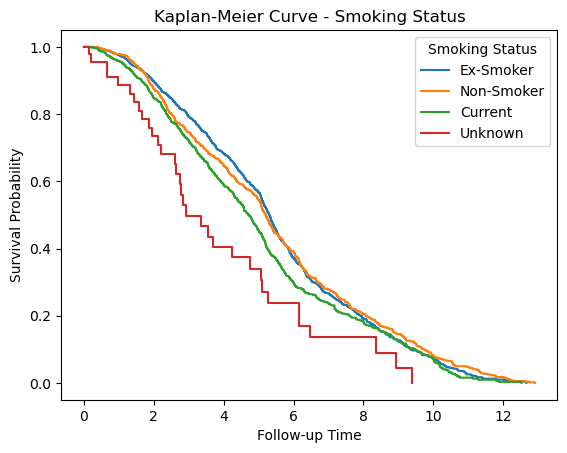

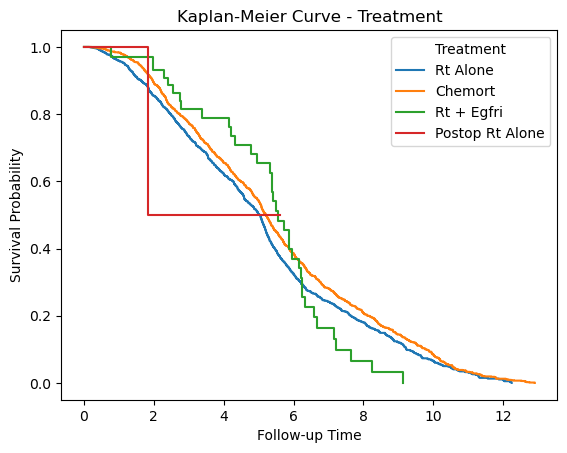

In [2]:
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Convert 'alive' to 0 and 'death' to 1
data1['Event'] = data1['Status'].apply(lambda x: 1 if x.lower() == 'alive' else 0)


# Filter for valid rows with non-null survival time and event
data_kmf = data1[['Length FU', 'Event', 'Smoking Status', 'Tx Modality']].dropna()

# Strip whitespace and unify capitalization (ChatGpt, 2025 - i used to check why do i have repeated variables Chemort on my graph)
data_kmf['Tx Modality'] = data_kmf['Tx Modality'].str.strip().str.title()

print(data_kmf["Tx Modality"].value_counts()) #check number of each variables in Tx Modality

#Kaplan_Meier fit for Smoking Status  and Status
kmf_smoking = KaplanMeierFitter()

for group in data_kmf['Smoking Status'].unique():
    obj = data_kmf['Smoking Status'] == group
    label = str(group).title() #get the group name
    kmf_smoking.fit(data_kmf[obj]['Length FU'], event_observed = data_kmf[obj]['Event'], label = label)
    kmf_smoking.plot_survival_function(ci_show=False)

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Curve - Smoking Status')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.legend(title = "Smoking Status")
plt.show()

#Kaplan_Meier fit for treatment type 
kmf_treatment = KaplanMeierFitter()

for group in data_kmf['Tx Modality'].unique():
    obj = data_kmf['Tx Modality'] == group
    label = str(group).title()
    kmf_treatment.fit(data_kmf[obj]['Length FU'], event_observed = data_kmf[obj]['Event'], label = label)
    kmf_treatment.plot_survival_function(ci_show = False)

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Curve - Treatment')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.legend(title = "Treatment")
plt.show()



**NOTE**: As Red line (Postop RT alone: Postoperative Radiotherapy) included very small samples (3), we can observe drastical drop with larger steps 

Reference: 
Van Houtte, P., Moretti, L., Charlier, F., Roelandts, M., & Van Gestel, D. (2021). Preoperative and postoperative radiotherapy (RT) for non-small cell lung cancer: still an open question. Translational lung cancer research, 10(4), 1950–1959. https://doi.org/10.21037/tlcr-20-472

In [3]:
#Log_rank_test 
from itertools import combinations 
#source: https://www.geeksforgeeks.org/python/permutation-and-combination-in-python/

# List of unique smoking groups
groups = data_kmf['Smoking Status'].unique()

# Pairwise comparisons
for group1, group2 in combinations(groups, 2):
    data_g1 = data_kmf[data_kmf['Smoking Status'] == group1]
    data_g2 = data_kmf[data_kmf['Smoking Status'] == group2]

    result = logrank_test(
        data_g1['Length FU'], data_g2['Length FU'],
        event_observed_A = data_g1['Event'],
        event_observed_B = data_g2['Event']
    )

    print(f"Log-rank test between '{group1}' and '{group2}':")
    result.print_summary()
    print("\n")
    
#List of unique treatment groups
groups2 = data_kmf['Tx Modality'].unique()

#Pairwise comparisions
for group1, group2 in combinations(groups2, 2):
    data_g1 = data_kmf[data_kmf['Tx Modality'] == group1]
    data_g2 = data_kmf[data_kmf['Tx Modality'] == group2]

    result = logrank_test(
        data_g1['Length FU'], data_g2['Length FU'],
        event_observed_A = data_g1['Event'],
        event_observed_B = data_g2['Event']
    )

    print(f"Log-rank test between '{group1}' and '{group2}':")
    result.print_summary()
    print("\n")

Log-rank test between 'Ex-smoker' and 'Non-smoker':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.42



Log-rank test between 'Ex-smoker' and 'Current':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.05 <0.005     10.14



Log-rank test between 'Ex-smoker' and 'unknown':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.95 <0.005     10.84



Log-rank test between 'Non-smoker' and 'Current':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.96 <0.005      8.50



Log-rank test between 'Non-smoker' and 'unknown':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.56 <0.005      9.76



Log-rank test between 'Current' and 'unknown':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.86 0.02      6.01



Log-rank test between 'Rt Alone' and 'Chemort':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.00 <0.005      8.53



Log-rank test between 'Rt Alone' and 'Rt + Egfri':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.03 0.86      0.22



Log-rank test between 'Rt Alone' and 'Postop Rt Alone':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.89      0.17



Log-rank test between 'Chemort' and 'Rt + Egfri':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.58 0.45      1.17



Log-rank test between 'Chemort' and 'Postop Rt Alone':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.95      0.08



Log-rank test between 'Rt + Egfri' and 'Postop Rt Alone':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.06 0.80      0.32

# 2. Cox Proportional Hazards Model

<lifelines.CoxPHFitter: fitted with 3319 total observations, 1050 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3319
number of events observed = 2269
   partial log-likelihood = -15673.50
         time fit was run = 2025-07-11 01:48:47 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
Smoking Status_Ex-smoker    -0.13      0.88      0.05           -0.22           -0.04                0.81                0.97
Smoking Status_Non-smoker   -0.12      0.88      0.05           -0.22           -0.03                0.80                0.97
Smoking Status_unknown       0.43      1.54      0.19            0.07            0.80                1.07                2.22
Tx Modality_ChemoRT          0.85      2.35      0.99           -1.09            2.80                0.33               16.48
Tx Modality_Postop RT alone -0.02      0.98      0.88           -1.74            1.70                0.18                5.47
Tx Modality_RT + EGFRI       0.10      1.10      0.15           -0.20            0.40                0.81                1.49
Tx Modality_RT alone         0.11      1.12      0.05            0.02            0.20                1.02                1.22
Stage_I                      0.05      1.05      0.08           -0.12            0.21                0.89                1.24
Stage_IB                     2.12      8.37      1.08            0.01            4.24                1.01               69.14
Stage_II                    -0.16      0.85      0.08           -0.32            0.00                0.73                1.00
Stage_IIA                    0.05      1.06      0.68           -1.28            1.39                0.28                4.00
Stage_IIB                   -0.28      0.75      2.79           -5.75            5.18                0.00              178.32
Stage_III                   -0.05      0.95      0.07           -0.20            0.09                0.82                1.10
Stage_IIIA                  -0.28      0.76      1.98           -4.15            3.59                0.02               36.35
Stage_IIIC                  -0.31      0.73      1.95           -4.14            3.52                0.02               33.66
Stage_IV                     0.05      1.05      0.42           -0.77            0.87                0.46                2.38
Stage_IVA                   -0.03      0.97      0.07           -0.17            0.10                0.85                1.11
Stage_IVB                   -0.04      0.96      0.09           -0.22            0.15                0.80                1.16
Stage_IVC                    1.93      6.90      0.75            0.47            3.39                1.60               29.81
Stage_X                      0.00      1.00      0.62           -1.22            1.22                0.30                3.40

                             cmp to     z    p  -log2(p)
covariate                                               
Smoking Status_Ex-smoker       0.00 -2.73 0.01      7.29
Smoking Status_Non-smoker      0.00 -2.49 0.01      6.29
Smoking Status_unknown         0.00  2.31 0.02      5.59
Tx Modality_ChemoRT            0.00  0.86 0.39      1.36
Tx Modality_Postop RT alone    0.00 -0.02 0.98      0.03
Tx Modality_RT + EGFRI         0.00  0.63 0.53      0.92
Tx Modality_RT alone           0.00  2.42 0.02      6.03
Stage_I                        0.00  0.58 0.56      0.83
Stage_IB                       0.00  1.97 0.05      4.36
Stage_II                       0.00 -1.94 0.05      4.25
Stage_IIA                      0.00  0.08 0.94      0.10
Stage_IIB                      0.00 -0.10 0.92      0.

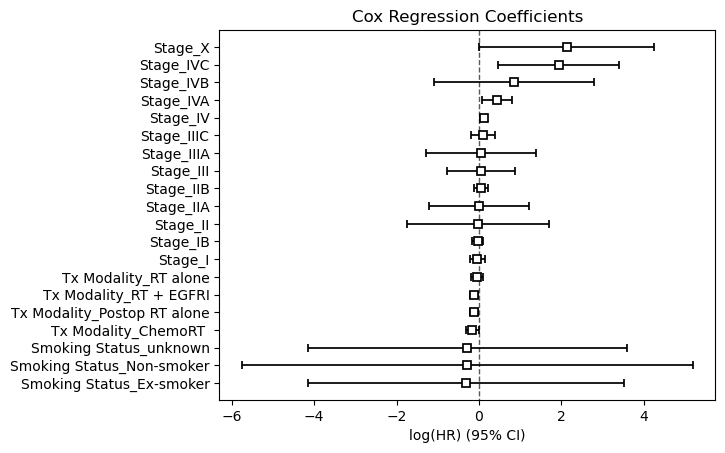

In [4]:
from lifelines import CoxPHFitter

#set dataset

data_cox = data1[['Length FU', 'Event', 'Smoking Status', 'Tx Modality', 'Stage']].dropna()

# Convert categorical variables into dummy variables (drop_first avoids multicollinearity)(
        # ChatGPT, 2025 - I used for error check and use resource for binary convertion)
        #resource: https://www.geeksforgeeks.org/python/how-to-convert-categorical-data-to-binary-data-in-python/
data_cox_encoded = pd.get_dummies(data_cox, columns=['Smoking Status', 'Tx Modality', 'Stage'], drop_first=True)

#fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer = 0.1)
cph.fit(data_cox_encoded, duration_col = 'Length FU',
        event_col = 'Event')

cph.print_summary()  # Print summary of the model with p-values < 0.05

#Plot the coefficients 
cph.plot()
plt.title('Cox Regression Coefficients')
#organize the yticks labels by each variable
plt.yticks(ticks=range(len(cph.params_)), labels=cph.params_.index) #(auto-coding in VS code guided me to use this code)
plt.show()


Both `ex-smokers` and `non-smokers` have significantly better survival than the reference group  (current smokers) (p < 0.05)

Only `RT alone` is significantly worse by 12% higher hazard (exp(coef) = 1.12, p < 0.05)

`Stage IV-C`: exp(coef) = 6.90, p = 0.01 → very poor survival.

Although the model was statistically significant overall, the concordance index (0.55) suggests limited predictive accuracy and highlights a need for further feature selection or modeling refinement.




# 3. Random Survival Forests

In [6]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

#set dataset - encode catergorical variables
# Drop missing values
data_survival = data1[['Length FU', 'Event', 'Smoking Status', 'Tx Modality', 'Stage']].dropna()
# Convert columns to categorical dtype
for col in ['Smoking Status', 'Tx Modality', 'Stage']:
    data_survival[col] = data_survival[col].astype('category')

# One-hot encode categorical variables
encoder = OneHotEncoder()
x_encoded = encoder.fit_transform(data_survival[['Smoking Status', 'Tx Modality', 'Stage']])

# Create structured survival object
y = Surv.from_arrays(event=data_survival['Event'].astype(bool),
                     time=data_survival['Length FU'])

# Train a Random Survival Forest model 
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(x_encoded, y)

# Feature importance using permutation importance
result = permutation_importance(rsf, x_encoded, y, n_repeats=15, random_state=42)

# Format results into DataFrame
feature_names = encoder.get_feature_names_out()
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance_Mean": result.importances_mean,
    "Importance_Std": result.importances_std
}).sort_values(by="Importance_Mean", ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance_Mean"],
         xerr=feature_importance["Importance_Std"], align='center')
plt.xlabel('Mean Importance')
plt.title('Feature Importances - Random Survival Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 